In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from joblib import dump
%matplotlib inline
from sklearn.metrics import mean_squared_error
np.random.seed(42)
from sklearn import neighbors
from math import sqrt

In [2]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')
gdrive_path = os.getcwd()

Mounted at /content/drive


In [3]:
path = Path.cwd() / "FOM_MA" / "Autos" / "date" / "Automobile_data_4000.csv"

In [ ]:
## Data understanding

In [123]:
df = pd.read_csv(path)

In [124]:
## Data preparation
df_amount_0 = df[ df['price'] == 0 ] 
df = df.drop(df_amount_0.index, axis=0) 

df = df.replace('?', np.nan)
df = df.dropna()

df.reset_index() 
df.index =range(len(df))

#deleting the columns 'Row_ID','Household_ID' from the dataframe as it is a unique and does not have any effect on the algorithm
del df['symboling']
del df['normalized-losses']

In [136]:
df.sample(10)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
1140,subaru,gas,std,four,hatchback,fwd,front,95.300003,163.089478,63.599998,54.500000,2044,ohc,four,92,2bbl,3.030000,3.030000,8.735538,59.588856,4800.00000,31,38,6330.225586
169,saab,gas,std,two,hatchback,rwd,front,94.500000,168.899994,66.109161,49.599998,2385,rotor,two,70,4bbl,3.030000,3.030000,9.500000,102.000000,6000.00000,16,22,14439.053711
2087,mitsubishi,gas,std,four,wagon,fwd,front,105.800003,193.044800,71.400002,55.700001,2917,ohc,five,141,mpfi,3.106712,3.400000,8.500000,114.000000,5500.00000,17,25,17880.427734
2431,volkswagen,gas,std,two,hatchback,fwd,front,87.907234,141.100189,60.300213,53.299999,1488,l,three,61,2bbl,2.892401,3.030000,9.500000,48.000114,5200.00000,45,51,5145.564453
3711,porsche,gas,std,four,hatchback,fwd,front,98.800003,176.600006,66.500000,51.599998,2385,ohc,four,141,mpfi,3.580000,3.861926,9.000000,86.028069,4200.00000,26,31,9989.101562
2250,mercedes-benz,gas,std,two,hatchback,fwd,front,93.037651,150.000000,63.799999,51.599998,1846,ohc,four,92,1bbl,2.955641,3.400000,9.500000,60.464710,4800.00000,48,53,6190.077148
3824,mitsubishi,gas,std,two,hatchback,fwd,front,94.500000,159.100006,63.799999,54.299999,1947,ohc,four,91,2bbl,3.051122,3.150000,9.300000,68.000000,5000.00000,31,38,6569.600586
2837,dodge,gas,std,two,hatchback,fwd,front,95.699997,156.206192,64.611298,54.299999,2027,ohc,four,98,1bbl,2.910000,3.410000,9.000000,76.135437,5868.42041,30,33,6844.919922
88,toyota,gas,std,four,sedan,rwd,front,105.425140,188.842957,67.199997,55.613770,3016,ohc,six,152,mpfi,3.168657,3.190000,9.300000,113.313087,4500.00000,21,25,18698.509766
2143,subaru,gas,std,two,convertible,rwd,front,101.984062,183.382523,65.400002,53.299999,2701,ohc,four,140,mpfi,3.478461,3.214512,9.200000,114.000000,5000.00000,24,29,16500.000000


In [126]:
df.shape

(3944, 24)

In [127]:
# Basic statistics of all columns
df.describe(include = 'all')

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,3944,3944,3944,3944,3944,3944,3944,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000,3944,3944,3944.000000,3944,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000
unique,22,2,2,2,5,3,2,NaN,NaN,NaN,NaN,NaN,7,7,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,toyota,gas,std,four,sedan,fwd,front,NaN,NaN,NaN,NaN,NaN,ohc,four,NaN,mpfi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,602,3613,3260,2167,1792,2273,3883,NaN,NaN,NaN,NaN,NaN,2786,3057,NaN,1863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.694847,173.810661,65.837789,53.696900,2551.403905,NaN,NaN,128.444473,NaN,3.315948,3.251434,9.901703,104.306226,5125.416653,24.955375,30.471349,13240.727123
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.772126,11.984154,2.055857,2.377230,527.585317,NaN,NaN,43.667129,NaN,0.269786,0.290871,3.603969,40.188996,437.619954,6.565655,6.736758,8138.812427
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.599998,141.100006,60.299999,47.799999,1488.000000,NaN,NaN,61.000000,NaN,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.500000,166.300003,64.000000,52.000000,2121.750000,NaN,NaN,97.000000,NaN,3.086891,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7554.066650
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.500000,173.199997,65.500000,54.099998,2414.000000,NaN,NaN,119.000000,NaN,3.270000,3.270000,9.000000,95.000000,5171.851318,24.000000,30.000000,10297.537109
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.695791,181.682076,66.650417,55.500000,2970.750000,NaN,NaN,146.000000,NaN,3.590000,3.400000,9.400000,116.483267,5500.000000,30.000000,34.000000,16511.904785


In [128]:
# Check the boolean characterics
print('Values of make:       {}'.format(df['make'].unique()))

Values of make:       ['nissan' 'toyota' 'mercedes-benz' 'plymouth' 'saab' 'volvo' 'honda'
 'subaru' 'volkswagen' 'peugot' 'mazda' 'mitsubishi' 'audi' 'bmw' 'isuzu'
 'jaguar' 'chevrolet' 'dodge' 'porsche' 'renault' 'alfa-romero' 'mercury']


In [ ]:
# Rename columns in order to correct spelling and get 'cleaned' names
df = df.rename(columns = {'Household_ID': 'Haushalt_ID',
                          'Vehicle': 'Fahrzeug',
                          'Calendar_Year': 'Kalenderjahr',
                          'Model_Year': 'Modelljahr',
                          'Blind_Make': 'Fahrzeugmarke',
                          'Blind_Model':'Modell',
                          'Blind_Submodel': 'Teilmodell',
                          'Claim_Amount': 'Preis'})

In [129]:
# Check the columns types
df.dtypes

make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

The total missing values in data 0


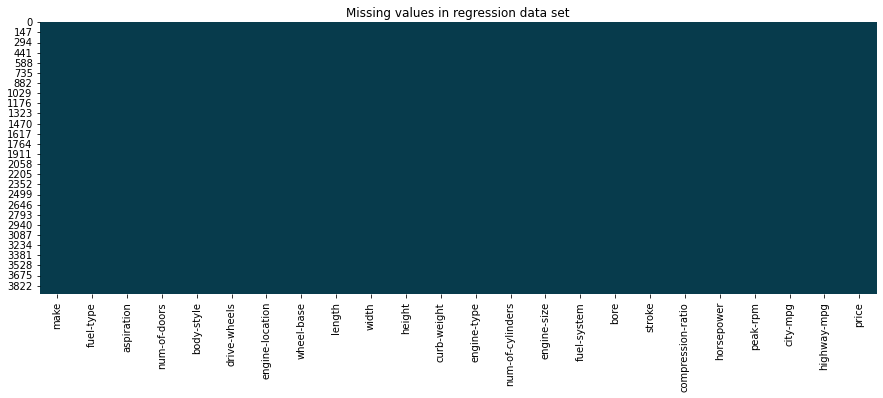

In [130]:
#checking for missing values:
print ("The total missing values in data",df.isnull().sum().sum())
#Feature engineering
f,(ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 5))
g1 = sns.heatmap(df.loc[:].isnull(), cmap = ['#073B4C', '#EF476F'], cbar = False, ax = ax1)
g1.set_title('Missing values in regression data set')
plt.draw()

In [138]:
df['curb-weight'] = df['curb-weight'].astype('float')
df['engine-size'] = df['engine-size'].astype('float')
df['city-mpg'] = df['city-mpg'].astype('float')
df['highway-mpg'] = df['highway-mpg'].astype('float')

In [139]:
#Korrelation
corr_matrix = df.corr()
corr_matrix["price"].sort_values(ascending = False)

price                1.000000
engine-size          0.843361
horsepower           0.817318
curb-weight          0.810686
width                0.783324
length               0.655096
bore                 0.574585
wheel-base           0.521926
stroke               0.038816
height               0.019256
compression-ratio   -0.004380
peak-rpm            -0.065014
highway-mpg         -0.692285
city-mpg            -0.715199
Name: price, dtype: float64

In [142]:
#creating 2 seperate dataframes for categorical and continuous features.
train_df_cat = pd.DataFrame()#training data frame with categorical features
train_df_cont = pd.DataFrame() #training data with continuous features
cat_list = []#list of categorical features
cont_list = []#list of continuous features

#populating the created data frames for categorical and continuous features
for each_column in df.columns:
    if df[each_column].dtype == 'float':
        cont_list.append(each_column)
cont_list.remove('price')
for each_column in df.columns:
    if df[each_column].dtype == 'object':
        cat_list.append(each_column)

for i in range(0,len(cat_list)):
    train_df_cat[i] = df[cat_list[i]]
train_df_cat.columns =cat_list
for i in range(0,len(cont_list)):
    train_df_cont[i] = df[cont_list[i]]
train_df_cont.columns =cont_list

In [144]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# Convert  attributes to string type columns
enc_df = pd.DataFrame(enc.fit_transform(train_df_cat[cat_list]).toarray())
df_preis = df['price']
df = train_df_cont.join(enc_df)
df

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,91.300003,157.300003,63.799999,49.700001,2190.0,102.0,3.15,3.100158,9.00000,85.898399,5400.000000,26.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,96.300003,173.997803,65.400002,51.400002,2409.0,109.0,3.15,3.460000,7.00000,114.396294,5500.000000,23.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,97.199997,176.199997,65.500000,54.900002,2322.0,110.0,3.27,3.520000,8.70000,90.000000,5500.000000,28.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94.500000,169.000000,63.900002,53.972446,2003.0,98.0,3.15,3.294734,9.40000,69.539200,5200.000000,31.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,114.199997,192.699997,69.745056,56.700001,3739.0,183.0,3.46,3.583720,22.91404,116.000000,4250.000000,23.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,95.699997,170.199997,65.400002,55.500000,2121.0,108.0,3.19,3.400000,9.00000,82.313522,5013.523926,26.0,33.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3940,102.900002,175.390259,66.500000,53.122231,2403.0,122.0,3.31,3.580000,9.00000,86.000000,4150.000000,27.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3941,95.699997,172.399994,66.500000,50.200001,2505.0,90.0,3.03,3.070000,9.60000,116.000000,6000.000000,16.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3942,96.300003,176.199997,63.599998,54.299999,2385.0,110.0,3.05,3.670542,9.00000,82.000000,5900.000000,27.0,33.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
## Modeling and evaluation
df_preis = df_preis.astype('int')

In [150]:
#Scaling
mm_scale = preprocessing.MinMaxScaler(feature_range = (-1, 1))
df = mm_scale.fit_transform(df) 

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,df_preis,test_size = 0.3,random_state = 42)

In [152]:
# PCA

In [154]:
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)
pca.n_components_

36

In [155]:
# Test Data
pca = PCA(n_components = 0.95)
X_test_reduced = pca.fit_transform(X_test)
X_train_reduced.shape,X_test_reduced.shape

((2760, 36), (1184, 36))

In [156]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 
d

36

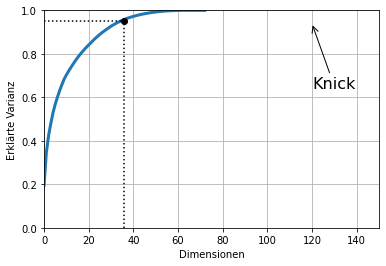

In [157]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 150, 0, 1])
plt.xlabel("Dimensionen")
plt.ylabel("Erklärte Varianz")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Knick", xy=(120, 0.94), xytext=(120, 0.64),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [158]:
X_train.shape,X_train_reduced.shape

((2760, 73), (2760, 36))

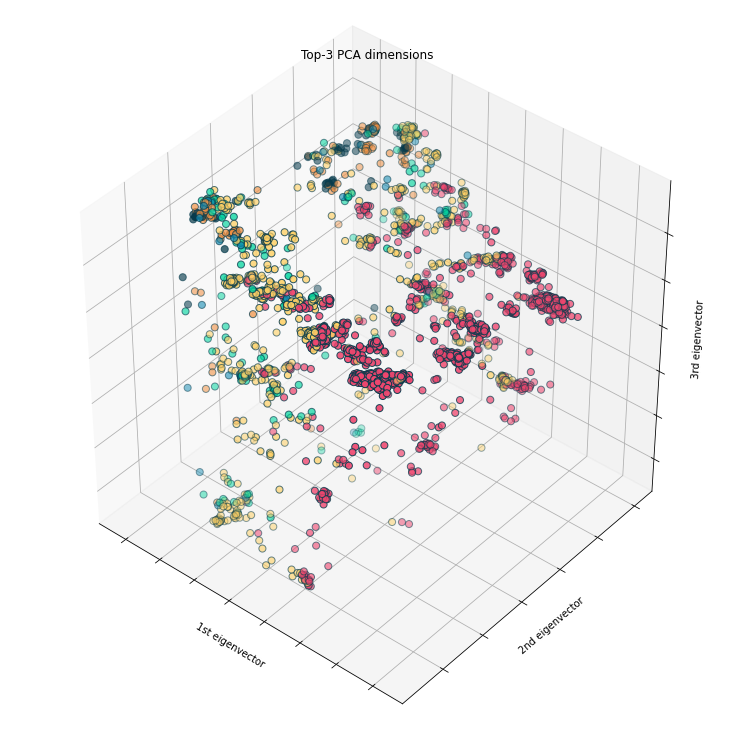

In [159]:
# Plot the result
owncmap = mc.ListedColormap(['#EF476F', '#FFD166', '#06D6A0', '#118AB2', '#F19143', '#073B4C'])
fig = plt.figure(1, figsize = (10, 10))
ax = Axes3D(fig, elev = -140, azim = 50)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2],      # first three dimensions of PCA
           c = y_train,                                               # color-coded by label
           cmap = owncmap, edgecolor = '#073B4C', s = 50)
ax.set_title("Top-3 PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.draw()

In [160]:
#print(pca.explained_variance_)                                    # absolute values
print(pca.explained_variance_ratio_)

[1.96123166e-01 1.47057270e-01 7.97054786e-02 5.60462019e-02
 4.99578688e-02 3.94061880e-02 3.27801353e-02 3.07458886e-02
 2.71119184e-02 2.49656218e-02 1.92500486e-02 1.74439444e-02
 1.64146161e-02 1.59590095e-02 1.50844857e-02 1.45307285e-02
 1.29992862e-02 1.24370352e-02 1.16404264e-02 1.08522524e-02
 1.06297334e-02 1.02649280e-02 1.02059384e-02 1.00010634e-02
 9.36534889e-03 8.70241598e-03 8.21170352e-03 7.58004560e-03
 7.27228700e-03 7.19690271e-03 7.13130341e-03 6.07398480e-03
 5.79484687e-03 5.39990931e-03 4.98833612e-03 4.85057582e-03
 4.43515166e-03 3.93662111e-03 3.55173014e-03 3.19278872e-03
 3.01391925e-03 2.72459617e-03 2.64158861e-03 2.51255453e-03
 2.20291172e-03 1.99027168e-03 1.94272890e-03 1.73934302e-03
 1.66188518e-03 1.41303459e-03 1.31354386e-03 1.23753036e-03
 1.08938980e-03 1.00479210e-03 9.63950308e-04 6.28060417e-04
 5.36768087e-04 5.28909911e-04 4.21556638e-04 3.87531706e-04
 3.29840828e-04 2.56248297e-04 1.61858140e-04 3.86784746e-32
 2.17012040e-33 1.507158

In [ ]:
##Modeling

In [ ]:
#Random Forest Regression

In [192]:
rf_reg = RandomForestRegressor(min_samples_leaf=105,n_estimators= 25,max_samples=2760, max_features=36,oob_score=True, random_state = 42)
rf_reg.fit(X_train_reduced,y_train)

score = rf_reg.score(X_train_reduced, y_train)
print("R-squared:", score)
rf_pred = rf_reg.predict(X_test_reduced)
mse = mean_squared_error(y_test, rf_pred)
print("MSE: ", mse)
print("RMSE: ", sqrt(mse))

R-squared: 0.7530490086003924
MSE:  21052021.9847153
RMSE:  4588.248247939


In [193]:
score = rf_reg.score(X_test_reduced, y_test)
print("R-squared:", score)

R-squared: 0.6973896880585744


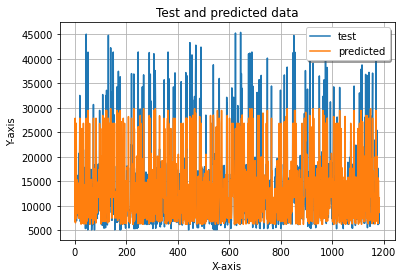

In [194]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, rf_pred, label="predicted")
plt.title("Test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [ ]:
#Decision tree

In [181]:
dt_reg = tree.DecisionTreeRegressor(min_samples_leaf=105,random_state = 42)
dt_reg.fit(X_train_reduced, y_train)

y_reg_pred = dt_reg.predict(X_test_reduced)
score = dt_reg.score(X_train_reduced, y_train)
print("R-squared:", score)
mse = mean_squared_error(y_test, y_reg_pred)
print("MSE: ", mse)
print("RMSE: ", sqrt(mse))

R-squared: 0.7915707882528583
MSE:  28557617.29302173
RMSE:  5343.9327552862915


In [182]:
score = dt_reg.score(X_test_reduced, y_test)
print("R-squared:", score)

R-squared: 0.5895012135357114


In [166]:
dt_reg.get_n_leaves(), len(X_train_reduced)

(20, 2760)

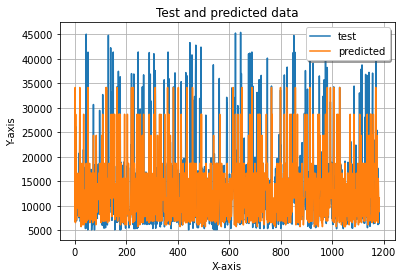

In [167]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, y_reg_pred, label="predicted")
plt.title("Test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

[Text(216.52826086956523, 205.35999999999999, 'X[0] <= 1.926\nmse = 64763661.117\nsamples = 2760\nvalue = 13153.672'),
 Text(141.92608695652174, 181.2, 'X[0] <= -0.117\nmse = 16188187.704\nsamples = 2135\nvalue = 10080.433'),
 Text(80.06086956521739, 157.04, 'X[0] <= -1.327\nmse = 4864096.096\nsamples = 1493\nvalue = 8191.753'),
 Text(43.66956521739131, 132.88, 'X[33] <= -0.186\nmse = 1913032.675\nsamples = 962\nvalue = 7214.989'),
 Text(29.11304347826087, 108.72, 'mse = 2521749.321\nsamples = 208\nvalue = 8752.712'),
 Text(58.22608695652174, 108.72, 'X[0] <= -1.967\nmse = 912864.45\nsamples = 754\nvalue = 6790.789'),
 Text(29.11304347826087, 84.56, 'X[1] <= -0.376\nmse = 604973.696\nsamples = 527\nvalue = 6472.518'),
 Text(14.556521739130435, 60.400000000000006, 'mse = 271970.356\nsamples = 203\nvalue = 6931.448'),
 Text(43.66956521739131, 60.400000000000006, 'X[33] <= -0.032\nmse = 598975.003\nsamples = 324\nvalue = 6184.978'),
 Text(29.11304347826087, 36.24000000000001, 'mse = 68924

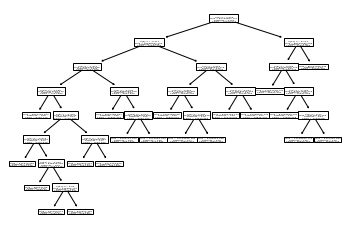

In [168]:
tree.plot_tree(dt_reg)

In [ ]:
#KNN

In [174]:
rmse_val = [] #to store rmse values for different k
for K in range(100):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_reduced, y_train)  #fit the model
    pred=model.predict(X_test_reduced) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 5977.639485271621
RMSE value for k=  2 is: 5565.490928966232
RMSE value for k=  3 is: 5403.473083535208
RMSE value for k=  4 is: 5349.2963573383995
RMSE value for k=  5 is: 5357.9569053979285
RMSE value for k=  6 is: 5394.233771758043
RMSE value for k=  7 is: 5375.005362142812
RMSE value for k=  8 is: 5343.134574330417
RMSE value for k=  9 is: 5334.930603589707
RMSE value for k=  10 is: 5324.504588878181
RMSE value for k=  11 is: 5333.851083704141
RMSE value for k=  12 is: 5355.092894960628
RMSE value for k=  13 is: 5362.762377504486
RMSE value for k=  14 is: 5353.215255056403
RMSE value for k=  15 is: 5326.211793690004
RMSE value for k=  16 is: 5329.618625330422
RMSE value for k=  17 is: 5354.843087570986
RMSE value for k=  18 is: 5350.480774516829
RMSE value for k=  19 is: 5356.994757933999
RMSE value for k=  20 is: 5340.7178902002315
RMSE value for k=  21 is: 5345.4553851188375
RMSE value for k=  22 is: 5348.817987319328
RMSE value for k=  23 is: 5345.994184

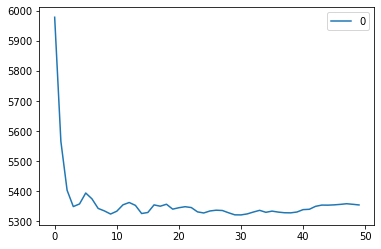

In [170]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [171]:
mse = mean_squared_error(y_test, pred)
print("MSE: ", mse)
print("RMSE: ", sqrt(mse))
score = model.score(X_train_reduced, y_train)
print("R-squared:", score)
#score = model.score(X_test_reduced, y_reg_test)
#print("R-squared:", score)

MSE:  28672047.897238847
RMSE:  5354.628642327948
R-squared: 0.8431168562702511


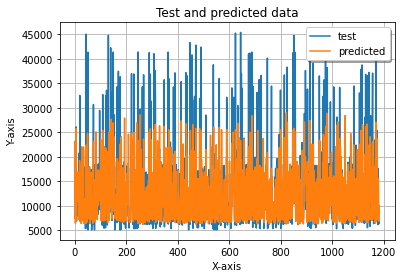

In [172]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, pred, label="predicted")
plt.title("Test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [173]:
score = model.score(X_test_reduced, y_test)
print("R-squared:", score)

R-squared: 0.5878563415674544


In [ ]:
#save

In [ ]:
dump(dt_reg,  Path.cwd() / "FOM_MA" / "ML" /'dt_reg.joblib')

['/content/drive/My Drive/FOM_MA/ML/dt_reg.joblib']